In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')

import re
import string
import datetime

import pickle

from sklearn.feature_extraction.text import CountVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

import pandas as pd
import numpy as np


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/metis/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/darienpmt/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /Users/darienpmt/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/darienpmt/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


# Import the dataframe with raw text

In [2]:
df = pd.read_csv('letters_df.csv', index_col=0)

In [3]:
df.Date =  pd.to_datetime(df.Date)

In [4]:
df.Date = df.Date.dt.strftime('%b %-d, %Y')

## Tokenize the documents as sentences

In [5]:
df['Sentences'] = df.Letter.apply(nltk.sent_tokenize) # if needed


# Sentiment Analysis

## Sentiment of each letter, tokenized by sentence

In [26]:
analyzer = SentimentIntensityAnalyzer()

In [27]:
def neg_sen(lst):
    neg = []
    for sentence in lst:
        neg.append(analyzer.polarity_scores(sentence)['neg'])
    return np.mean(neg)

In [28]:
def neu_sen(lst):
    neu = []
    for sentence in lst:
        neu.append(analyzer.polarity_scores(sentence)['neu'])
    return np.mean(neu)

In [29]:
def pos_sen(lst):
    pos = []
    for sentence in lst:
        pos.append(analyzer.polarity_scores(sentence)['pos'])
    return np.mean(pos)

In [30]:
def comp_sen(lst):
    comp = []
    for sentence in lst:
        comp.append(analyzer.polarity_scores(sentence)['compound'])
    return np.mean(comp)

In [31]:
df['negative'] = df.Sentences.apply(neg_sen)
df['neutral'] = df.Sentences.apply(neu_sen)
df['positive'] = df.Sentences.apply(pos_sen)
df['compound'] = df.Sentences.apply(comp_sen)

## Sentiment over the entire duration of the war

In [34]:
df.index = pd.to_datetime(df.Date)

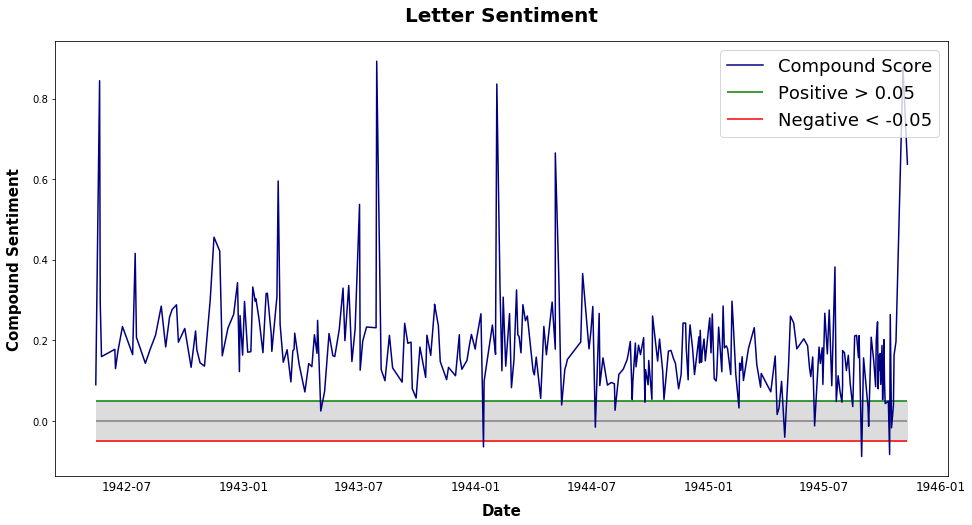

In [81]:
# plot letter compound score over time
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(df.index, df['compound'], color='navy')
plt.hlines(0.05, xmin='1942-05-13', xmax='1945-11-10', color='green')
plt.hlines(-0.05, xmin='1942-05-13', xmax='1945-11-10', color='red')
plt.hlines(0, xmin='1942-05-13', xmax='1945-11-10', color='gray')
plt.fill_between(df.index, -0.05, 0.05, color='gainsboro')

plt.legend(['Compound Score','Positive > 0.05', 'Negative < -0.05'], prop={'size': 18})
plt.title('Letter Sentiment', fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=15, weight='bold',labelpad=10)
plt.ylabel('Compound Sentiment', fontsize=15,weight='bold',labelpad=10)

ax.tick_params(axis="x", labelsize=12, length=0)
ax.tick_params(axis="y", labelsize=10);

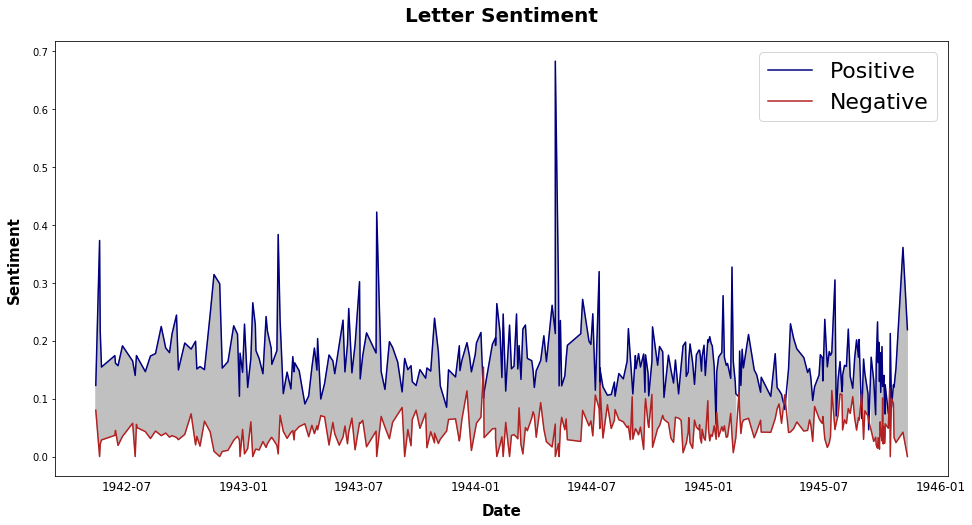

In [82]:
# plot letter sentiment over time comparing positive and negative scores
fig, ax = plt.subplots(figsize=(16,8))

plt.plot(df.index, df.positive, color='navy')
plt.plot(df.index, df.negative, color='firebrick')
plt.fill_between(df.index, df.negative,  df.positive, where=df.positive>df.negative, color='silver')

plt.legend(['Positive', 'Negative'], prop={'size': 22})
plt.title('Letter Sentiment', fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=15, weight='bold',labelpad=10)
plt.ylabel('Sentiment', fontsize=15,weight='bold',labelpad=10)

ax.tick_params(axis="x", labelsize=12, length=0)
ax.tick_params(axis="y", labelsize=10);

Let's try to find those spikes and see what was going on then!

In [ ]:
# used this to find the most positive and negative letters

df.sort_values('negative').head(15)

In [ ]:
# the most negative letter

df.Letter.loc['1945-10-13']

In [124]:
# to make the word clouds in EDA
neg_indices = df.sort_values('compound').head(10).index

In [125]:
# to make the word clouds in EDA
pos_indices = df.sort_values('compound', ascending=False).head(10).index

In [88]:
df.Date = pd.to_datetime(df.Date)

## Sentiment by location

In [92]:
df_main_locations = df[~df.Location.isin(['Mindanao', 'Leyte', 'California', 'Okinawa'])]

### Group data by location for graphing

In [94]:
locations = df_main_locations.groupby('Location')

### Group data by location, mean polority scores

In [95]:
locations_means = df_main_locations.groupby('Location').mean()
locations_means

,negative,neutral,positive,compound
Location,,,,
Australia,0.038489,0.780347,0.181163,0.221797
Japan,0.046823,0.828282,0.124900,0.104516
New Guinea,0.041716,0.770351,0.187935,0.214821
Philippine Islands,0.057887,0.797259,0.144855,0.126406
Southwest Pacific,0.049942,0.785257,0.164800,0.160594
Zamboanga,0.066591,0.785808,0.147600,0.122928


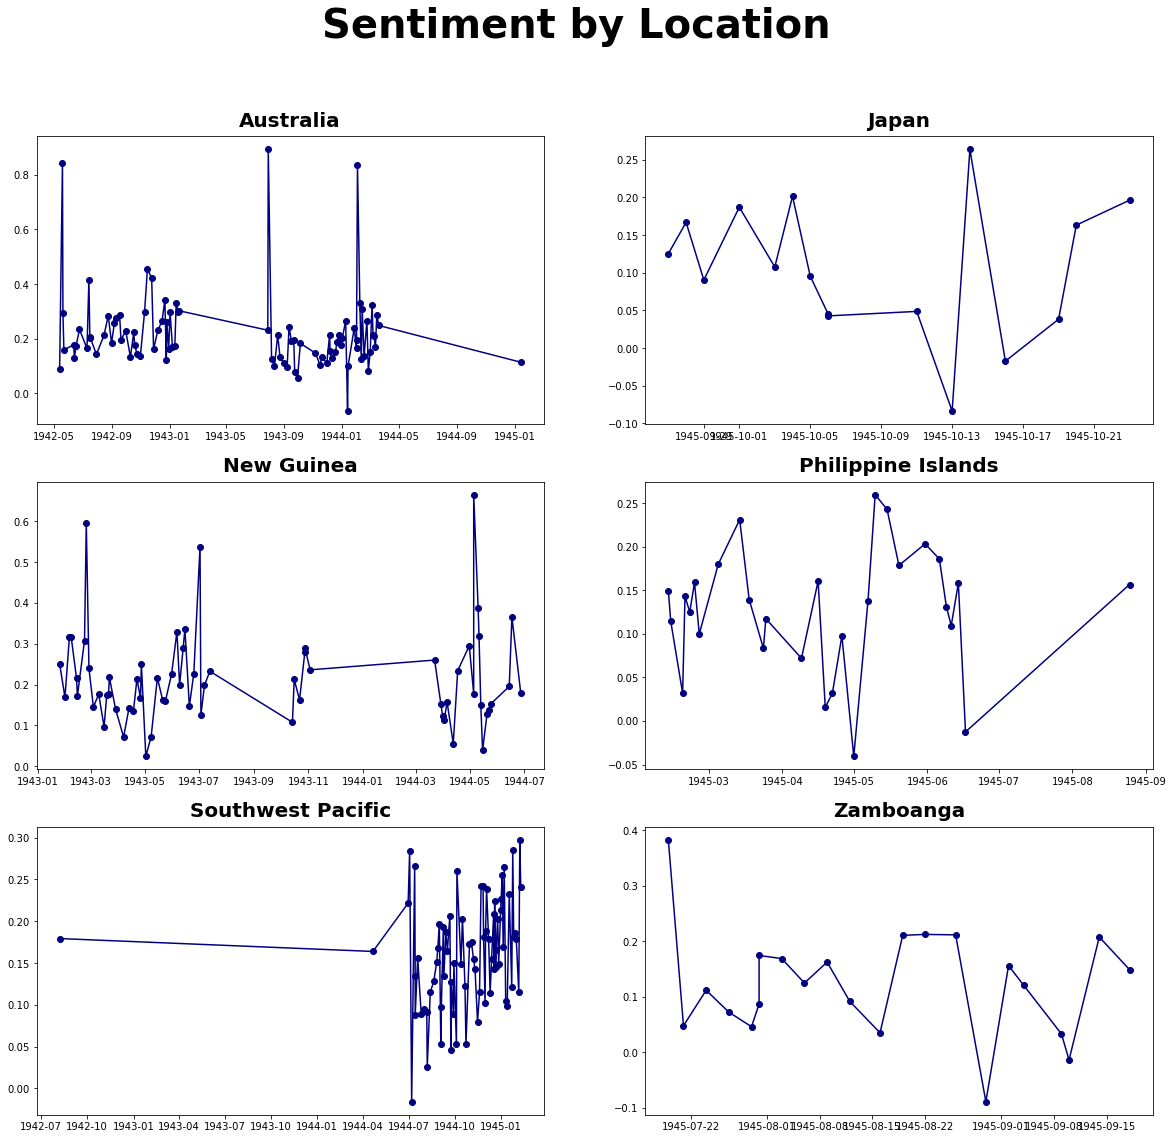

In [98]:
plt.rcParams['figure.figsize'] = [20, 18]

for index, local in enumerate(locations):

    plt.subplot(3, 2, index+1)
    plt.plot(local[1].index, local[1]['compound'], '-o', color='navy')

    plt.suptitle('Sentiment by Location', fontsize=40, weight='bold')
    plt.title(str(local[0]), fontsize=20, weight='bold', pad=10)

    ax.tick_params(axis="x", labelsize=12, length=0)
    ax.tick_params(axis="y", labelsize=10);

# Sentiment by quarter

In [108]:
df_qrt = df.resample('3M').mean()

## Positive and Negative Polarity

In [ ]:
# plot letter sentiment over time

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(df_qrt.index, df_qrt.positive, '-o', color='navy')
plt.plot(df_qrt.index, df_qrt.negative, '-o', color='firebrick')
plt.fill_between(df_qrt.index, df_qrt.negative,  df_qrt.positive, 
                 where=df_qrt.positive>df_qrt.negative, color='silver')

periods = ['May, 1942', 'June - Aug, 1942', 'Sep - Nov, 1942', 'Dec 1942 - Feb 1943',
           'March - May, 1943', 'June - Aug, 1943', 'Sep - Nov , 1943', 'Dec 1943 - Feb 1944',
           'March - May, 1944', 'June - Aug, 1944', 'Sep - Nov, 1944', 'Dec 1944 - Feb 1945',
           'March - May, 1945', 'June - Aug, 1945', 'Sep - Nov, 1945']

plt.legend(['% Positive', '% Negative'], prop={'size': 22})
plt.title('Letter Sentiment - Quarterly', fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=15, weight='bold',labelpad=10)
plt.ylabel('Sentiment', fontsize=15,weight='bold',labelpad=10)

ax.tick_params(axis="x", labelsize=12, length=0)
ax.tick_params(axis="y", labelsize=10);

## Comound Score

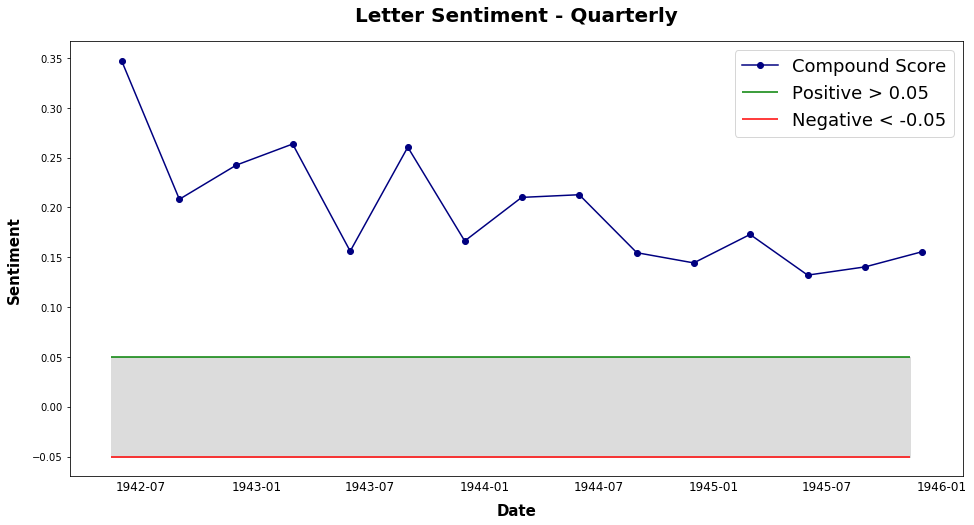

In [149]:
# plot letter sentiment over time

fig, ax = plt.subplots(figsize=(16,8))

plt.plot(df_qrt.index, df_qrt['compound'], '-o', color='navy')


periods = ['May, 1942', 'June - Aug, 1942', 'Sep - Nov, 1942', 'Dec 1942 - Feb 1943',
           'March - May, 1943', 'June - Aug, 1943', 'Sep - Nov , 1943', 'Dec 1943 - Feb 1944',
           'March - May, 1944', 'June - Aug, 1944', 'Sep - Nov, 1944', 'Dec 1944 - Feb 1945',
           'March - May, 1945', 'June - Aug, 1945', 'Sep - Nov, 1945']

# plt.legend(['Positive', 'Negative'], prop={'size': 22})
plt.title('Letter Sentiment - Quarterly', fontsize=20, weight='bold', pad=20)
plt.xlabel('Date', fontsize=15, weight='bold',labelpad=10)
plt.ylabel('Sentiment', fontsize=15,weight='bold',labelpad=10)

plt.hlines(0.05, xmin='1942-05-13', xmax='1945-11-10', color='green')
plt.hlines(-0.05, xmin='1942-05-13', xmax='1945-11-10', color='red')

plt.fill_between(df.index, -0.05, 0.05, color='gainsboro')
plt.legend(['Compound Score','Positive > 0.05', 'Negative < -0.05'], prop={'size': 18})


ax.tick_params(axis="x", labelsize=12, length=0)
ax.tick_params(axis="y", labelsize=10);

In [112]:
df_qrt.to_pickle('./pickles/letter_sentiment_by_qrt.pkl')

# Time between letters

Look at how much time had passed between letters and see if that correlates with sentiment at all.

In [113]:
# make a copy of the dataframe

time_delta = df.copy()

In [114]:
# we don't need the sentence column for this

time_delta.drop('Sentences', axis=1, inplace=True)

In [115]:
# make sure the dates are datetime objects

time_delta.Date = pd.to_datetime(time_delta.Date)

In [116]:
# find the difference in days

time_delta['Days_between_letters'] = time_delta.Date.diff().astype('timedelta64[D]')

In [ ]:
# convert days between letters to integers

time_delta.Days_between_letters = time_delta.Days_between_letters.apply(int)

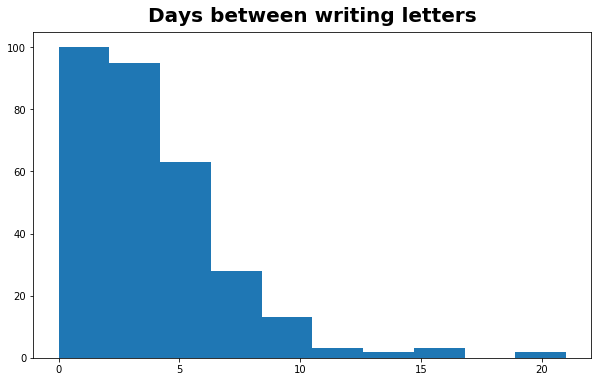

In [122]:
# look at basic distribution of delta

plt.figure(figsize=(10,6))
plt.hist(time_delta.Days_between_letters)
plt.title('Days between writing letters', fontsize=20, weight='bold', pad=10);

Looks like the man was pretty consistent!

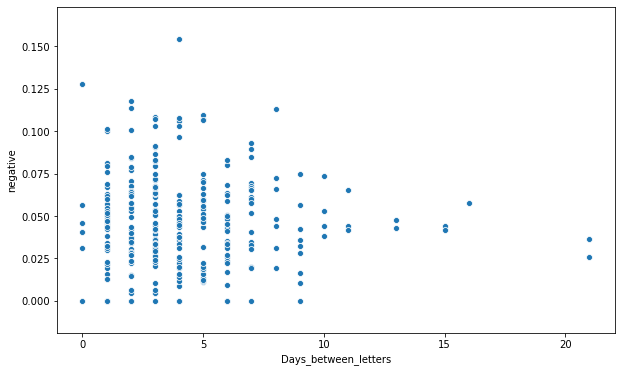

In [120]:
plt.figure(figsize=(10,6))
sns.scatterplot(time_delta.Days_between_letters, time_delta.negative);

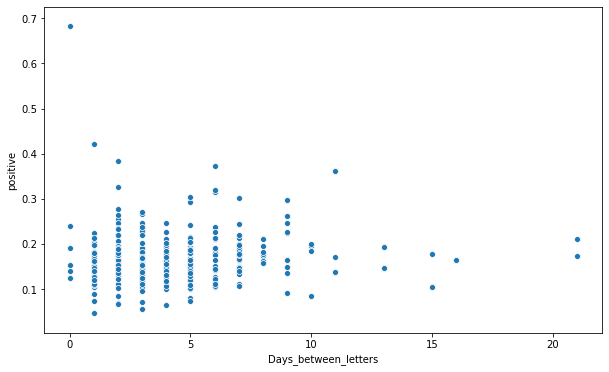

In [121]:
plt.figure(figsize=(10,6))
sns.scatterplot(time_delta.Days_between_letters, time_delta.positive);

Nothing interesting to see here...